# Test Model
- test model on holdout sessions

In [32]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import json

In [33]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [34]:
n_hl = 10

# Define Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, n_hl),
            nn.ReLU(),
            nn.Linear(n_hl, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  

model = MLP().to(device)
model.load_state_dict(torch.load('model/model-epoch9.pt'))
    
criterion = nn.BCEWithLogitsLoss()

In [62]:
# Predict with model but only the smoking session (not other activies)

index = 36
step = 10000    # for memory

start = 0
stop = 0
with open(f'data/{index}/{index}_data.json', 'r') as f:
    annot = json.load(f)
    start = annot['start'] // 5
    stop = annot['end'] // 5

# Read in holdout session
dataset = torch.load(f'pipeline/holdouts/{index}-holdout.pt')[start:stop]
session_length = len(dataset[0])
X = dataset[:][0]
y_true = dataset[:][1]

model.eval()

X = X.to(device) 
y = y_true.to(device)

logits = model(X)
pred = torch.round(nn.Sigmoid()(logits))

n_correct = sum(y == pred)
loss = criterion(logits, y).item()

y_pred = np.array(pred.cpu().detach()).reshape(-1,1)
accuracy = (n_correct / session_length).item()
print(f'Accuracy: {100*accuracy:.4}%')
print(f'Loss: {loss:.4}')

Accuracy: 94.01%
Loss: 1.191


In [77]:
# Visualize predictions
df = pd.read_csv(f'pipeline/1_dm/{index}.csv')[start:stop+99]
df['y_true'] = np.pad(y_true.flatten()*1, (49, 50), mode='constant', constant_values=0)
df['y_pred'] = np.pad(y_pred.flatten()*1, (49, 50), mode='constant', constant_values=0)

figure = px.line(df)
figure.show(renderer='browser')

Opening in existing browser session.


Gtk-Message: 17:45:59.780: Failed to load module "xapp-gtk3-module"
Gtk-Message: 17:45:59.781: Failed to load module "appmenu-gtk-module"


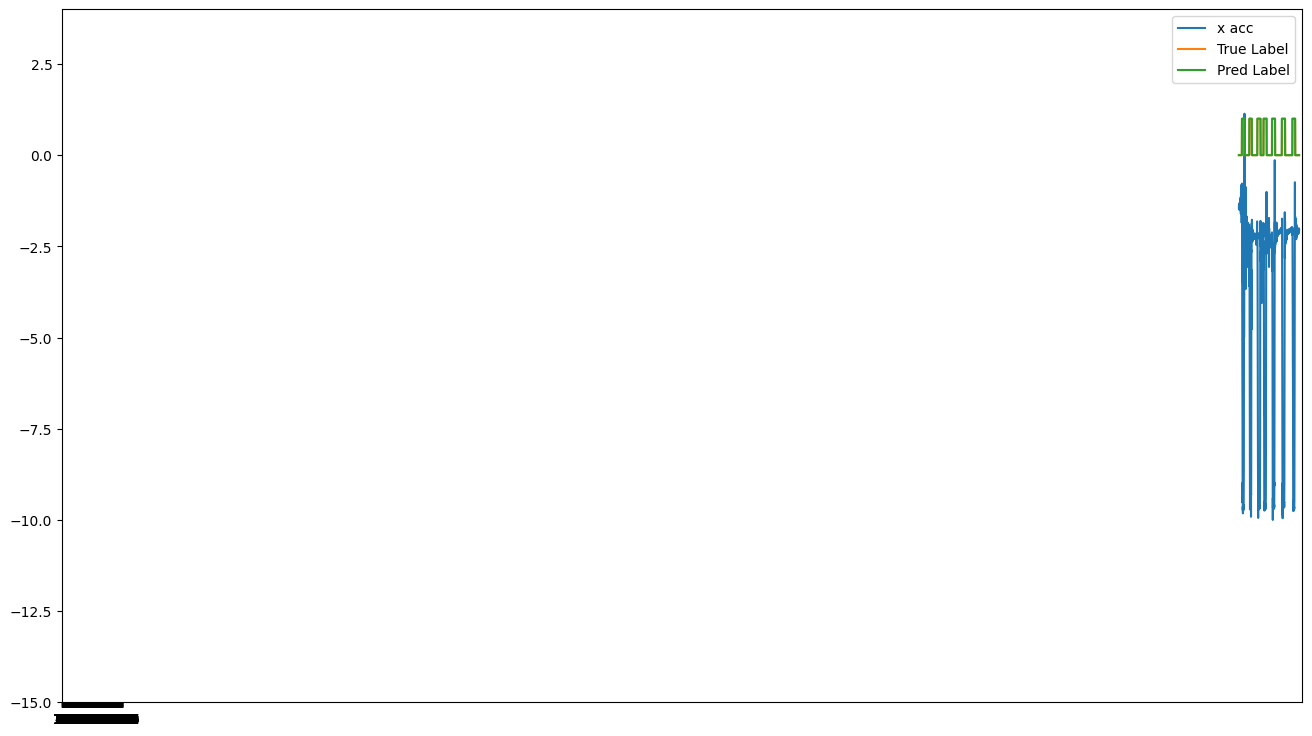

In [92]:
# Save fig

fig, ax = plt.subplots(1, figsize=(16,9))
ax.plot(df.drop(['y','z'], axis=1).iloc[600:], label=['x acc', 'True Label', 'Pred Label'])
ax.legend()
ax.set_ylim(-15, 4)
plt.savefig('cont.jpg', dpi=400)

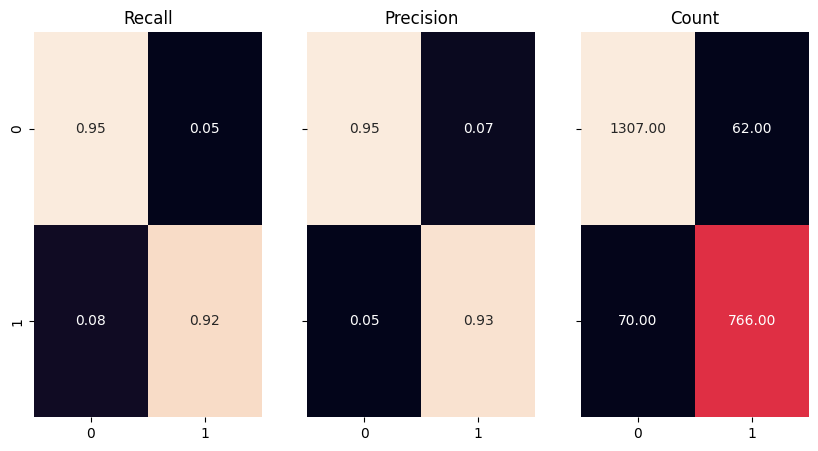

In [65]:
# Heatmap

y_true = dataset[:][1]

fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Count')
plt.savefig(f'cm.jpg',dpi=200,bbox_inches='tight')

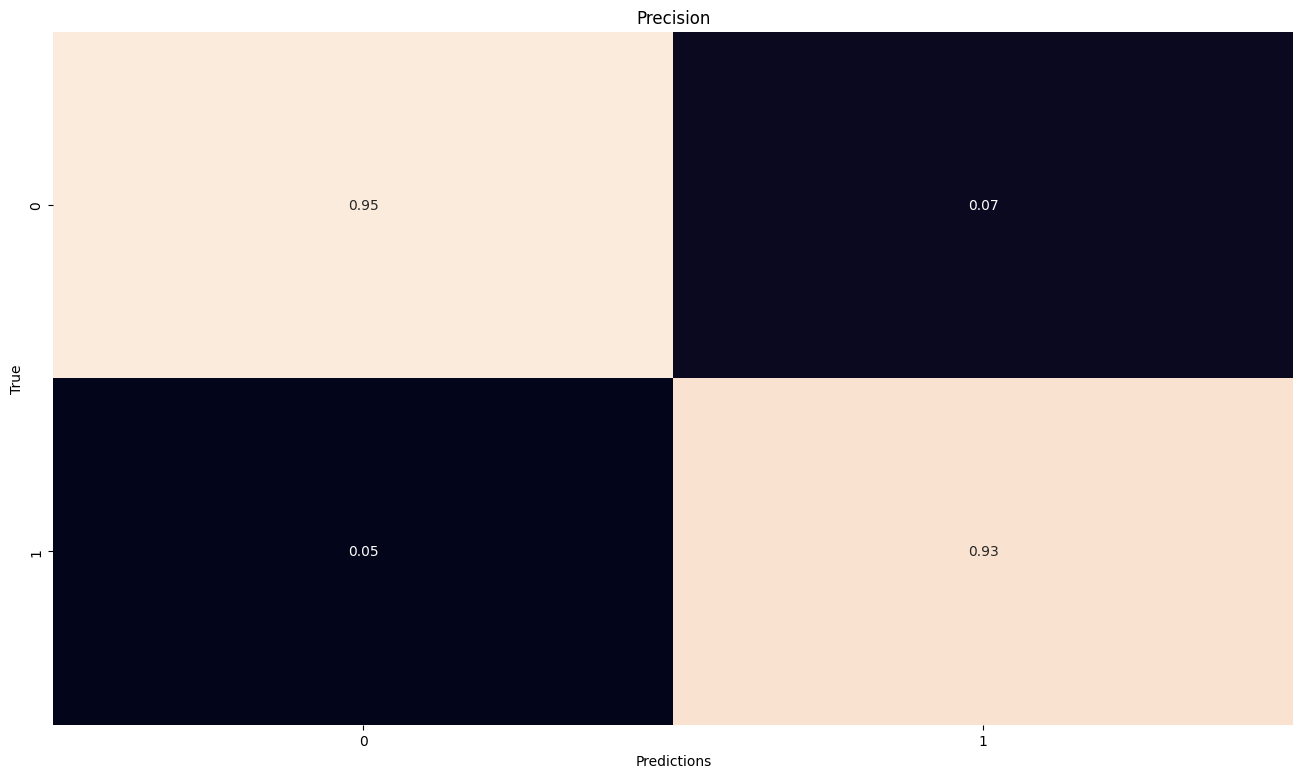

In [66]:
# Confusion Matrix (precision)

y_true = dataset[:][1]

fig,axes = plt.subplots(1,figsize=(16,9))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes,cbar=False,fmt='.2f')
axes.set_title('Precision')
axes.set_xlabel("Predictions")
axes.set_ylabel("True")
plt.savefig(f'cm_pres.jpg',dpi=400,bbox_inches='tight')